In [1]:
# pip3 install opencv-python numpy matplotlib
import cv2 as cv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
from scipy.signal import find_peaks



In [2]:
# Create necessary dirs if they do not exist
direc= os.getcwd()
dirs = [direc+ "/linesdetected", direc+ "/output", direc+ "/cropped"]

for path in dirs:
    isExist = os.path.exists(path)

    if not isExist:
  
      # Create a new directory because it does not exist 
      os.makedirs(path)
      print("The new directory -{0} \n is created!".format(path))

In [3]:
# Source: https://medium.com/analytics-vidhya/binarization-of-image-using-numpy-65df2b82e189
def read_this(image_file, gray_scale=False):
    image_src = cv.imread(image_file)
    if gray_scale:
        image_src = cv.cvtColor(image_src, cv.COLOR_BGR2GRAY)
    else:
        image_src = cv.cvtColor(image_src, cv.COLOR_BGR2RGB)
    return image_src

In [4]:
import cv2
import numpy as np

#identify paragraps
# Load image, grayscale, Gaussian blur, Otsu's threshold
def contourFinder(img_path):
    contour = []
    image_orig = cv2.imread(img_path)
    gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours and draw rectangle
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    cropped = [];
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
    
        if (w*h < 40*40):
            continue
        if(len(cnts) > 1 and x == 0 and y==0 and w>=image_orig.shape[1] and h>=image_orig.shape[0]):
            continue
        contour.append(c)
        cropped.append(image_orig[y:y+h, x:x+w])
        cv2.rectangle(image_orig, (x, y), (x + w, y + h), (15,100,10), 2)
    
#cv2.imshow('thresh', thresh)
#cv2.imshow('dilate', dilate)
#cv2.imshow('image', image_orig)
    i=0
    for k in cropped:
        cv2.imwrite('cropped/cropped_image' + str(i) +'.png', k)
        i= i+1
    cv2.waitKey()
    return [i, contour]

In [5]:
def blackAndWhite(file):
    img = cv2.imread(file)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width, *rest= img.shape

    for i in range(height):
        for j in range(width):
            if img[i, j] == 0:
                img[i, j] =255
            else:
                img[i, j] = 0
    return img

In [6]:
def calculateYProjection(array):
    img_row_sum = []
    for i in range(len(array)):
        img_row_sum.append(np.sum(array[i],axis=1).tolist())
    return img_row_sum

In [7]:
def calculatePeaks(array):
    peaks_of_image = []
    for i in range(len(array)):
        x =array[i]
        peaks, _ = find_peaks(x, distance=15)
        peaks_of_image.append(peaks)
    return peaks_of_image

In [8]:
def makeLines(array, peaks_image):
    images = array  
    for k,image in enumerate(array):
        newImage = image.copy()
        height, width= newImage.shape
        for i in range(height):
            if(i in peaks_image[k]):
                for j in range(width):
                    try:
                        newImage[i,j] = 255
                        newImage[i-1,j] = 255
                        newImage[i+1,j] = 255
                        newImage[i-2,j] = 255
                        newImage[i+2,j] = 255
                        newImage[i-3,j] = 255
                        newImage[i+3,j] = 255
                    except Exception as e:
                        continue
                        print("out of boundaries")
        plt.imshow(newImage, cmap='Greys_r')
        cv2.imwrite('linesdetected/cropped_image' + str(k) +'.png', newImage)

In [9]:
def assembleImage(original_image_size , contours, filename):

    img = Image.new('RGB', original_image_size[::-1] )
    plt.imshow(img, cmap='Greys_r')
    for idx, c in enumerate(contours):
        x,y,w,h = cv2.boundingRect(c)
        cr= Image.open('linesdetected/cropped_image' + str(idx) +'.png')
        plt.imshow(cr,cmap='Greys_r' )
        img.paste(cr, (x,y))
    img.save("output/" + filename[:-4] + "predicted.png")

In [10]:
def save_image(image, old_name, dir):
    if('_binarized' not in old_name):
        index = dir.find('.jpg')
        final_string = dir[:index] + '_binarized' + dir[index:]
        image.save(final_string)

In [11]:
def applyBinarizationAndSave():
    dir = os.getcwd()
    try:
        #assuming this file is one directory upper than images
        directory = os.fsencode(dir + '/images/')
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                image_dir = dir + '/images/' + filename
                binarized_image = ApplyOtsu(image_file=image_dir)
                save_image(binarized_image, filename, image_dir)
            else:
                continue
                
    except Exception as e:
        print(e)

In [12]:
def ApplyOtsu(image_file, thresh_val=127, gray_scale=True):
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    #blur = cv.GaussianBlur(image_src,(5,5),0)
    th, image_b = cv.threshold(image_src, 127, 255, cv.THRESH_BINARY+ cv.THRESH_OTSU)
    return Image.fromarray(image_b)

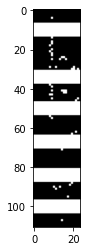

In [13]:
import os
import glob
def main():
    applyBinarizationAndSave()
    direc= os.getcwd()
    for img in glob.glob(direc + '/images' + '/*binarized*.jpg'):
        image_orig = cv2.imread(img)
        number_of_images, contours = contourFinder(img)

        array = []
        img_row_sum = []
        peaks_image = []


        for filename in glob.glob(direc + '/cropped' + '/*.png'):
            array.append(blackAndWhite(filename))
    
        img_row_sum = calculateYProjection(array)  

        peaks_image= calculatePeaks(img_row_sum)

        makeLines(array, peaks_image)

        k =image_orig.shape[:-1]
        assembleImage(k, contours, img.split("\\")[-1])

if __name__ == "__main__":
    main()  

In [ ]:
# From here on parts from old code will be presented
    



In [ ]:
import cv2
import numpy as np
#identify paragraps
# Load image, grayscale, Gaussian blur, Otsu's threshold
image_orig = cv2.imread('./images/fmb-cb-55-027v_binarized.jpg')
gray = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours and draw rectangle
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

cropped = [];
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    
    if (w*h < 40*40):
        continue
    if(len(cnts) > 1 and x == 0 and y==0 and w>=image_orig.shape[1] and h>=image_orig.shape[0]):
        continue

    cropped.append(image_orig[y:y+h, x:x+w])
    cv2.rectangle(image_orig, (x, y), (x + w, y + h), (15,100,10), 2)
    
#cv2.imshow('thresh', thresh)
#cv2.imshow('dilate', dilate)
#cv2.imshow('image', image_orig)
i=0
for k in cropped:
    cv2.imwrite('cropped/cropped_image' + str(i) +'.png', k)
    i= i+1
cv2.waitKey()

In [ ]:
horizontal_projection = np.sum(image1, axis=1)
print(horizontal_projection)
print(image1.shape)
blankImage = np.zeros((height, width, 3), np.uint8)
plt.figure()
plt.imshow(blankImage, cmap='Greys_r')
for row in range(height):
    cv2.line(blankImage, (0,row), (int(horizontal_projection[row]*width/height),row), (255,255,255), 1)

In [ ]:
plt.hist(image1.ravel(), 256, [0,256])
plt.show()

In [ ]:
img_row_sum = np.sum(image1,axis=1).tolist()

plt.plot(img_row_sum)
plt.show()